In [25]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as sp
import matplotlib.pyplot as plt
import json
import logging
import warnings
import sys
import os
import shutil 
import subprocess
import time
from datetime import datetime
import humanize 
from tqdm import tqdm

warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)


# Function to get the current git tag
def get_git_tag():
        try:
            tag = subprocess.check_output(["git", "describe", "--tags"], stderr=subprocess.DEVNULL).strip().decode()
            return tag
        except subprocess.CalledProcessError:
            return "No tag found"

def create_directories(*paths):
    """Creates multiple directories if they don't exist."""
    for path in paths:
        os.makedirs(path)


def plot_and_save_all_metrics(df_results, sampler_colors, varying_attribute, varying_attribute_for_plot, results_folder, plots_folder, run_id, config_descr):
    """
    Generates and saves multiple metric plots for different samplers.

    Parameters:
    - df_results: DataFrame containing experiment results.
    - sampler_colors: Dictionary mapping sampler names to colors.
    - varying_attribute: The attribute that varies.
    - varying_attribute_for_plot: The attribute used for plotting.
    - plots_folder: Folder where plots should be saved.
    - run_id: ID of the current run.
    - config_descr: Description of the configuration.
    """
    
    # Define metric labels
    metrics = ["wasserstein_distance", "r_hat", "ess", "runtime"]

    # Initialize plots for all metrics
    fig_ax_pairs = {key: plt.subplots(figsize=(10, 6)) for key in metrics}

    # Iterate over samplers and plot all metrics
    for sampler in df_results["sampler"].unique():
        df_sampler = df_results[df_results["sampler"] == sampler]
        csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
        df_sampler.to_csv(csv_filename, index=False)

        for metric in metrics:
            fig, ax = fig_ax_pairs[metric]
            ax.plot(df_sampler[varying_attribute_for_plot], df_sampler[metric], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))

    # Set dynamic axis labels and save plots
    attribute_label = "Mode Distance" if varying_attribute == "mu" else varying_attribute.replace("_", " ").title()

    for metric in metrics:
        fig, ax = fig_ax_pairs[metric]
        finalize_and_save_plot(fig,ax, attribute_label, metric, 
                               f"{metric} for Samplers (config =_{config_descr})",
                               os.path.join(plots_folder, f"{metric}_run_{run_id}.pdf"))




def compute_and_save_global_metrics(df_all_runs, sampler_colors, varying_attribute, runs, config_descr, global_results_folder, global_plots_folder):
    """
    Computes and saves global metric plots (averaged across runs) for different samplers.

    Parameters:
    - df_all_runs: DataFrame containing results from all runs.
    - sampler_colors: Dictionary mapping sampler names to colors.
    - varying_attribute: The attribute that varies.
    - runs: Number of experiment runs.
    - config_descr: Configuration description.
    - global_results_folder: Folder to save CSVs.
    - global_plots_folder: Folder to save plots.
    """

    df_all_runs = df_all_runs.sort_values(varying_attribute, ascending=True)
    varying_attribute_for_plot = varying_attribute

    # Define metrics for aggregation
    metrics = ["wasserstein_distance", "r_hat", "ess", "runtime"]

    # Initialize global plots
    #fig_ax_pairs_bars = {metric: plt.subplots(figsize=(10, 6)) for metric in metrics}

    # New figure set (line + fill)
    fig_ax_pairs_shaded = {metric: plt.subplots(figsize=(10, 6))
                       for metric in metrics}

    for sampler in df_all_runs["sampler"].unique():
        df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]
        color = sampler_colors.get(sampler, "black")


        # Pivot tables: rows = varying attribute, columns = run_id, values = metric
        df_pivot = {metric: df_sampler.pivot_table(index=varying_attribute_for_plot, columns="run_id", values=metric)
                    for metric in metrics}

        # Compute mean and standard deviation
        metric_stats = {metric: (df_pivot[metric].mean(axis=1), df_pivot[metric].std(axis=1))
                        for metric in metrics}

        for metric, (mean, std) in metric_stats.items():
            #fig_bar, ax_bar = fig_ax_pairs_bars[metric]
            #ax_bar.errorbar(mean.index, mean, yerr=std, fmt="o-", label=sampler, color=color, capsize=5)

            # New figure set (line + shaded area)
            fig_shaded, ax_shaded = fig_ax_pairs_shaded[metric]
            ax_shaded.plot(mean.index, mean, "o-", label=sampler, color=color)
            ax_shaded.fill_between(mean.index, mean - std, mean + std, 
                                color=color, alpha=0.2)
            
        # Save global averages CSV
        df_global_avg = pd.DataFrame({
            varying_attribute: metric_stats["wasserstein_distance"][0].index,
            **{f"global_avg_{metric}": metric_stats[metric][0].values for metric in metrics},
            **{f"global_avg_{metric}_std": metric_stats[metric][1].values for metric in metrics},
        })


        csv_filename = os.path.join(global_results_folder, f"Global_results_{sampler}.csv")
        df_global_avg.to_csv(csv_filename, index=False)

    # Save plots
    attribute_label = "Mode Distance" if varying_attribute == "mu" else varying_attribute.replace("_", " ").title()
    for metric in metrics:
        #fig_bar, ax_bar = fig_ax_pairs_bars[metric]
        #finalize_and_save_plot(fig_bar, ax_bar, attribute_label, metric,
        #                       f"Averaged {metric.replace('_', ' ').title()} ({runs} Runs, config = {config_descr})",
        #                       os.path.join(global_plots_folder, f"{metric}_global_plot.pdf"))
        
        fig_shaded, ax_shaded = fig_ax_pairs_shaded[metric]
        finalize_and_save_plot(fig_shaded, ax_shaded, attribute_label, metric,
                               f"Averaged {metric.replace('_', ' ').title()} ({runs} Runs, config = {config_descr})",
                               os.path.join(global_plots_folder, f"{metric}_global_plot_shaded.pdf"))



def finalize_and_save_plot(fig, ax, xlabel, ylabel, title, save_path):
    """
    Finalizes the plot with labels, grid, and saves it to a file.
    
    Parameters:
    - fig: Matplotlib figure
    - ax: Matplotlib axis
    - xlabel: Label for x-axis
    - ylabel: Label for y-axis
    - title: Title of the plot
    - save_path: Path to save the figure.
    """
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title="Sampler")
    ax.grid(True)
    fig.savefig(save_path, bbox_inches="tight")
    plt.close(fig)



def plot_histogram(samples, title, save_path=None, posterior_type=None):
    """
    Plots a histogram and KDE of the given samples.

    Parameters:
    - samples: 1D or 2D array of samples.
    - title: Title of the plot.
    - save_path: If provided, saves the figure to this path.
    """
    plt.figure(figsize=(8, 6))

    if samples.ndim == 2:
        # Handle multivariate case
        if samples.shape[1] == 2:
            plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, label="2D Samples")
            plt.xlabel("Dimension 1")
            plt.ylabel("Dimension 2")
            plt.title(title)
            plt.legend()
            plt.grid(True)
        elif posterior_type == "MvNormal" and samples.shape[1] > 2:
            print(f"Skipping plotting: Multivariate Normal with dimension {samples.shape[1]}.")
            return
        
    else:
        # Standard 1D histogram + KDE
        plt.hist(samples, bins=50, alpha=0.5, density=True, color='blue', edgecolor='black', label="Histogram")
        sns.kdeplot(samples, color='red', lw=2, label="KDE")
        plt.title(title)
        plt.xlabel("Sample Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    else:
        plt.show()



def generate_iid_samples(posterior_type = None, num_samples=2000, rng=None,**params):
    """
    Generate IID samples from a mixture distribution.

    Parameters:
    - component_types: List of strings specifying the type of each component (e.g., ["normal", "beta"]).
    - component_params: List of dictionaries with parameters for each component.
    - num_samples: Number of samples to generate.
    - weights: List of weights for the components.
    - rng: Random number generator.

    Returns:
    - iid_samples: Array of generated IID samples.
    """

    rng = rng or np.random.default_rng()

    # Mapping from string names to scipy sampling functions
    scipy_distributions = {
        "Normal": lambda p: sp.norm.rvs(loc=p["mu"], scale=p["sigma"], size=num_samples, random_state=rng),
        "StudentT": lambda p: sp.t.rvs(df=p["nu"], loc=p["mu"], scale=p["sigma"], size=num_samples, random_state=rng),
        "Beta": lambda p: sp.beta.rvs(a=p["a"], b=p["b"], size=num_samples, random_state=rng),
        "Cauchy": lambda p: sp.cauchy.rvs(loc=p["loc"], scale=p["scale"], size=num_samples, random_state=rng),
        "Laplace": lambda p: sp.laplace.rvs(loc=p["mu"], scale=p["b"], size=num_samples, random_state=rng),
        "MvNormal": lambda p: rng.multivariate_normal(mean=np.array(p["mu"]), cov=np.array(p["cov"]), size=num_samples),
    }

    # Handle Skewed Student-T (which needs PyMC)
    if posterior_type == "SkewStudentT":
        with pm.Model():
            skewed_t = pm.SkewStudentT.dist(a=params["a"], b=params["b"], mu=params["mu"], sigma=params["sigma"])
            return pm.draw(skewed_t, draws=num_samples, random_seed=rng)

    # Handle single distributions
    if posterior_type in scipy_distributions:
        print(f"Generating {posterior_type} samples...", params)
        return scipy_distributions[posterior_type](params)

    elif posterior_type == "Mixture":
        component_types = params["component_types"]
        component_params = params["component_params"]
        weights = params["weights"]

        if len(component_types) != len(component_params):
            raise ValueError("Each component type must have a corresponding parameter dictionary.")

        # normalize weights
        weights = np.array(weights) / np.sum(weights)

        # Choose which component each sample belongs to based on weights
        chosen_components = rng.choice(len(component_types), size=num_samples, p=weights)

        posterior_dim = None  

        # Check if all components have the same dimension
        for comp_params in component_params:
            first_param = next(iter(comp_params))  # Get first parameter of current component
            first_value = comp_params[first_param]  # Get its value
            comp_dim = len(first_value) if isinstance(first_value, (np.ndarray, list)) else 1 # Get dimensionality of the first parameter

            if posterior_dim is None:
                posterior_dim = comp_dim  # Set the posterior dimension based on the first component
               
            elif comp_dim != posterior_dim:
                raise ValueError("All mixture components must have the same dimensionality.")

        if posterior_dim > 1:
            iid_samples = np.empty((num_samples, posterior_dim))  # Multivariate case
        else:
            iid_samples = np.empty(num_samples)

        for i, (comp_type, comp_params) in enumerate(zip(component_types, component_params)):
            mask = chosen_components == i  # Select samples for this component
            num_selected = mask.sum()
            if num_selected > 0:
                if comp_type in scipy_distributions or comp_type == "SkewStudentT":
                    iid_samples[mask] = generate_iid_samples(posterior_type=comp_type, num_samples=num_selected, rng=rng, **comp_params)
                else:
                    raise ValueError(f"Unsupported component type in IID sampling: {comp_type}")
                
        return iid_samples
    
    else:
        raise ValueError(f"Unsupported posterior type: {posterior_type}")


def extract_means_from_components(component_params):
    """
    Extracts central tendency (mu or loc) from each component's parameters.
    """
    means = []
    for params in component_params:
        if "mu" in params:
            means.append(params["mu"])
        elif "loc" in params:
            means.append(params["loc"])
        else:
            raise ValueError("Component missing a central tendency parameter (mu or loc).")
    return means


def get_initvals(init_scheme, means, num_chains, rng=None):
    """Generates initialization values based on the chosen scheme."""

    if init_scheme == "equal_per_mode":
        initvals = [{"mixed_post_var": means[i % len(means)]} for i in range(num_chains)]


    elif init_scheme == "all_in_middle":
        means_array = np.array(means)
        middle_point = np.mean(means_array, axis=0)
        initvals = [{"mixed_post_var": middle_point} for _ in range(num_chains)]

    elif init_scheme == "random":
        means_array = np.array(means)
        if means_array.shape[0] < 2:
            raise ValueError("random init_scheme requires at least 2 modes.")
            
        # Compute bounding box across all dimensions
        min_mode = np.min(means_array, axis=0)
        max_mode = np.max(means_array, axis=0)
        border = (max_mode - min_mode) / len(means)

        low = min_mode - border
        high = max_mode + border

        initvals = [
            {"mixed_post_var": rng.uniform(low, high)}
            for _ in range(num_chains)
        ]


    elif init_scheme.startswith("all_near_mode_"):
        try:
            mode_index = int(init_scheme.split("_")[-1])
            if mode_index >= len(means):
                raise IndexError(f"Mode index {mode_index} out of bounds for available means.")
            initvals = [{"mixed_post_var": means[mode_index]} for _ in range(num_chains)]
        except ValueError:
            raise ValueError(f"Invalid mode index in init_scheme: '{init_scheme}'")

    print(f"Initvals: {initvals}")

    return initvals


def sliced_wasserstein_distance(X, Y, L=100):
    """
    Computes the sliced Wasserstein distance (SWD_p) between two sets of samples.
    
    Parameters:
    - X: numpy array of shape (N, d) -> first sample set
    - Y: numpy array of shape (N, d) -> second sample set
    - L: int, number of random projections
    - p: int, order of Wasserstein distance (default: 1)
    
    Returns:
    - SWD_p: float, the sliced Wasserstein distance
    """
    
    #X = X.reshape(-1, 1)
    #Y = Y.reshape(-1, 1)
    # Ensure X and Y are at least 2D

    N, d = X.shape  # Assuming X and Y have the same shape
    S = 0  # Accumulation variable

    for _ in range(L):
        # Sample a random unit vector (projection direction)
        theta = np.random.randn(d)
        theta /= np.linalg.norm(theta)  # Normalize to unit sphere

        # Compute projections
        alpha = X @ theta
        beta = Y @ theta

        # Compute 1D Wasserstein distance
        W_i = sp.wasserstein_distance(alpha, beta)

        # Accumulate
        S += W_i

    # Compute final SWD
    SWD_p = (S / L) 

    return SWD_p


class PosteriorExample:
    """Base class for different posterior types."""
    
    def __init__(self):
        self.model = None  # Placeholder for the PyMC model
    
    def _define_posterior(self):
        """Subclasses should implement this method to define the posterior."""
        raise NotImplementedError("Subclasses must implement _define_posterior()")

    def run_sampling(self, sampler_name, num_samples=2000, tune=1000, num_chains=2, initvals=None, init_scheme=None, run_random_seed=None):
        """Runs MCMC sampling using the chosen sampler."""
        
        with self.model:

            # Define which sampler to use
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")
           
            if init_scheme != None:
                trace = pm.sample(num_samples, tune=tune, step=sampler,initvals=initvals, chains=num_chains, return_inferencedata=True, progressbar=False, random_seed=run_random_seed)    #initvals=initvals,
            else:
                trace = pm.sample(num_samples, tune=tune, step=sampler, chains=num_chains, return_inferencedata=True, progressbar=False, random_seed=run_random_seed)
        
        return trace


class SinglePosterior(PosteriorExample):
    def __init__(self, dist_name, dist_params):
        """
        A flexible class for defining unimodal posteriors.

        Parameters:
        - dist_name: String specifying the name of the PyMC distribution (e.g., "Normal", "StudentT").
        - dist_params: Dictionary containing the parameters for the distribution.
        """
        self.dist_name = dist_name
        self.dist_params = dist_params
        super().__init__()
        self.model = self._define_posterior()

    def _define_posterior(self):
        
        dist_class = getattr(pm, self.dist_name)   # Retrieve the distribution class from PyMC
        
        with pm.Model() as model:
            posterior_var = dist_class("posterior_var", **self.dist_params)
        return model


class MixturePosterior(PosteriorExample):
    
    def __init__(self, component_types, component_params, weights=None, varying_component=None): 
        """
        A flexible mixture posterior allowing any number of components and arbitrary distributions.

        Parameters:
        - component_types: List of strings specifying the type of each component (e.g., ["normal", "beta"]).
        - component_params: List of dictionaries, where each dictionary contains the parameters for the corresponding distribution.
        - weights: List of weights for the mixture components (defaults to uniform).
        """
        if len(component_types) != len(component_params):
            raise ValueError("Each component type must have a corresponding parameter dictionary.")

        if weights is None:
            weights = np.ones(len(component_types))  # Default: Equal weights

        if len(weights) != len(component_types):
            raise ValueError("Number of weights must match number of components.")

        self.component_types = component_types
        self.component_params = component_params
        self.weights = weights

        # Normalize weights
        self.weights = np.array(self.weights) / np.sum(self.weights)
        
        super().__init__()
        self.model = self._define_posterior()


    def _define_posterior(self):
        
        # Construct component distributions dynamically
        components = []
        for dist_type, params in zip(self.component_types, self.component_params):
            try:
                dist_class = getattr(pm, dist_type)  # Retrieve PyMC distribution dynamically
                components.append(dist_class.dist(**params))  # Use `.dist()` to create distribution
            except AttributeError:
                raise ValueError(f"Unsupported distribution type: {dist_type}")
            
        # Define the mixture model    
        with pm.Model() as model:
            # Mixture model
            mixed_post_var = pm.Mixture("mixed_post_var", w=self.weights, comp_dists=components)

        return model
    

class CustomPosterior(PosteriorExample):
    """
    A flexible class to define custom posteriors using a user-specified log-probability function.
    """

    def __init__(self, logp_func):
        """
        Parameters:
        - logp_func: Callable function that defines the log-probability.
                     Must accept PyMC symbolic variables.
        - param_names: List of parameter names required by logp_func.
        - initvals: Optional dictionary for initial values.
        """
        super().__init__()
        self.logp_func = logp_func
        self.model = self._define_posterior()

    def _define_posterior(self):
        with pm.Model() as model:

            # Define the custom distribution using pm.CustomDist
            custom_var = pm.CustomDist("cust_var", logp=self.logp_func, shape=(2,))

        return model
    

def run_experiment(
    experiment_settings,
    posterior_type,
    config_descr,
    runs,
    varying_attribute, 
    varying_values,      
    num_samples,
    num_chains,
    init_scheme=None,
    base_random_seed=None,
    progress_bar=None,
    **posterior_kwargs
):
    print(f"\n===== Config {config_descr} started! =====\n")

    # Initialize random number generator
    rng = np.random.default_rng(base_random_seed)

    # Define required parameters for each posterior type
    required_parameters = {
        "Mixture": ["component_types", "component_params", "weights"],
        "Cauchy": ["loc", "scale"],
        "Beta": ["a", "b"],
        "Normal": ["mu", "sigma"],
        "StudentT": ["nu", "mu", "sigma"],
        "SkewStudentT": ["a", "b", "mu", "sigma"],
        "Laplace": ["mu", "b"],
        "MvNormal": ["mu", "cov"],
        "Custom": []
    }

    # Validate that required keys exist (except for varying attributes)
    required_keys = [k for k in required_parameters.get(posterior_type) if k != varying_attribute]
    if not all(k in posterior_kwargs for k in required_keys):
        raise ValueError(f"{posterior_type} posterior requires {required_keys}")

    # Create keyword arguments for IID sample generation
    iid_kwargs = {key: posterior_kwargs.get(key, "varies") for key in required_parameters.get(posterior_type)}

    print(f"Using IID sample settings: {iid_kwargs}")

    # Create configuration and histogram folders inside the experiment root
    config_folder = os.path.join(experiment_root_folder, f"{config_descr}_with_{runs}_runs")
    iid_histogram_folder = os.path.join(config_folder, "KDE and Histograms of IID Samples")
    create_directories(config_folder, iid_histogram_folder)

    # === Handle Precomputed IID Samples for Varying Attributes ===
    iid_samples_dict = {}

    if posterior_type == "Mixture":
        component_index = posterior_kwargs.get("varying_component")  # Get the selected component

        if component_index is None and varying_attribute not in ["num_samples", "num_chains", "init_scheme"]:
            raise ValueError(f"`varying_component` must be specified when varying '{varying_attribute}' in a Mixture.")

        # Loop through all varying values for Mixture posterior
        for value in varying_values:

            iid_kwargs["component_params"][component_index][varying_attribute] = value
            print(f"Updating component {component_index} with {varying_attribute} = {value}")

            iid_samples_dict[value] = generate_iid_samples(
                posterior_type=posterior_type,
                component_types=iid_kwargs["component_types"],
                component_params=iid_kwargs["component_params"], 
                weights=iid_kwargs["weights"],
                num_samples=num_samples,
                rng=rng
            )

            # Plot histogram and KDE for each varying value
            plot_histogram(
                samples=iid_samples_dict[value],
                title=f"IID Samples Histogram & KDE ({varying_attribute}={value})",
                save_path=os.path.join(iid_histogram_folder, f"iid_hist_kde_{varying_attribute}_{value}.pdf"),
                posterior_type=posterior_type
            )


    elif posterior_type == "Custom":
        # Skip generating any IID samples here.
        pass
        

    # Single posterior case
    elif varying_attribute in iid_kwargs or varying_attribute == "num_samples":
        for value in varying_values:
            if varying_attribute == "num_samples":
                current_num_samples = value  
            else:
                iid_kwargs[varying_attribute] = value  
                current_num_samples = num_samples  
            
            iid_samples_dict[value] = generate_iid_samples(
                posterior_type=posterior_type,
                **iid_kwargs,
                num_samples=current_num_samples,
                rng=rng
            )

            # Plot histogram and KDE for each varying value
            plot_histogram(
                samples=iid_samples_dict[value],
                title=f"IID Samples Histogram & KDE ({varying_attribute}={value})",
                save_path=os.path.join(iid_histogram_folder, f"iid_hist_kde_{varying_attribute}_{value}.pdf"),
                posterior_type=posterior_type
            )

    # Fixed posterior case (no varying attributes)
    else:
        iid_samples = generate_iid_samples(
            posterior_type=posterior_type,
            **iid_kwargs,
            num_samples=num_samples,
            rng=rng
        )

        plot_histogram(
            samples=iid_samples,
            title="IID Samples Histogram & KDE (fixed posterior)",
            save_path=os.path.join(iid_histogram_folder, "iid_hist_kde.pdf"),
            posterior_type=posterior_type
        )


    # === Experiment Setup ===
    samples_per_chain = "varies" if varying_attribute in ["num_samples", "num_chains"] else num_samples // num_chains

    experiment_metadata = {
        "config_descr": config_descr,
        "runs": runs,
        "posterior_type": posterior_type,
        "varying_attribute": varying_attribute,
        "varying_values": varying_values,
        "num_samples": num_samples,
        "num_chains": num_chains,
        "samples_per_chain": samples_per_chain,
        "init_scheme": init_scheme,
        "base_random_seed": base_random_seed,
        "git_tag": get_git_tag(),
    }
    experiment_metadata.update(iid_kwargs)  # Add posterior-specific parameters

    # Save metadata
    metadata_filename = os.path.join(config_folder, f"metadata_config_{config_descr}.json")
    with open(metadata_filename, "w") as f:
        json.dump(experiment_metadata, f, indent=4)

    # Define fixed colors for each sampler
    sampler_colors = {
        "Metro": "blue",
        "HMC": "red",
        "DEMetro": "green"
    }

    # === Run the Experiment ===
    for run_id in range(1, runs + 1):
        print(f"\n===== Running {config_descr} - Run {run_id} =====\n")

        run_random_seed = int(rng.integers(1_000_000))

        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")
        traces_folder = os.path.join(run_folder, "traces_and_trace_plots")
        plots_folder = os.path.join(run_folder, "plots_of_run")
        

        create_directories(run_folder, results_folder, traces_folder, plots_folder)

        results = []

        for value in varying_values:

            var_attr_folder = os.path.join(traces_folder, f"{varying_attribute}_{value}")
            create_directories(var_attr_folder)

            # Handle parameter changes for Mixture case
            if posterior_type == "Mixture":
                component_index = posterior_kwargs.get("varying_component")
                if component_index is None and varying_attribute not in ["num_samples", "num_chains", "init_scheme"]:
                    raise ValueError(f"`varying_component` must be specified when varying '{varying_attribute}' in a Mixture.")

                # Modify only the selected component
                posterior_kwargs["component_params"][component_index][varying_attribute] = value
            
            else:
                if varying_attribute in iid_kwargs:
                    posterior_kwargs[varying_attribute] = value
            
            if varying_attribute == "num_samples":
                num_samples = value
                samples_per_chain = num_samples // num_chains
            elif varying_attribute == "num_chains":
                num_chains = value
                samples_per_chain = num_samples // num_chains
            elif varying_attribute == "init_scheme":
                init_scheme = value

            if posterior_type == "Mixture":
                model = MixturePosterior(**posterior_kwargs)
            elif posterior_type == "Custom":
                logp_func = posterior_kwargs["logp_func"]
                model = CustomPosterior(logp_func=logp_func)
            else:
                model = SinglePosterior(dist_name=posterior_type, dist_params=posterior_kwargs)

            # Generate initialization values
            if posterior_type == "Mixture" and init_scheme is not None:
                means = extract_means_from_components(posterior_kwargs["component_params"])
                initvals = get_initvals(init_scheme, means, num_chains, rng)
            else:
                initvals = None
           

            # Get IID samples for the current varying value
            if posterior_type != "Custom" and varying_attribute not in ["init_scheme", "num_chains"]:
                iid_samples = iid_samples_dict[value]
            elif posterior_type == "Custom":
                iid_samples = None


            # Run sampling for all samplers
            for sampler_name in ["Metro", "HMC", "DEMetro"]:
                
                if posterior_type == "Mixture":
                    print(f"Running {sampler_name} with {varying_attribute} = {value} (Component {component_index})")
                else:
                    print(f"Running {sampler_name} with {varying_attribute} = {value}")

                # **Measure Computation Time**
                start_time = time.time()
                trace = model.run_sampling(
                    sampler_name, num_samples=samples_per_chain, num_chains=num_chains, init_scheme=init_scheme,
                    initvals = initvals, run_random_seed=run_random_seed
                )
                end_time = time.time()
                runtime = end_time - start_time

                # Plot trace plots in notebook if requested
                if experiment_settings.get("plot_traces_in_notebook", False):
                    az.plot_trace(trace, compact=True)
                    plt.title(f"Trace Plot ({sampler_name}, {varying_attribute} = {value})")
                    plt.show()
                

                # Save trace to NetCDF file if requested
                if experiment_settings.get("save_traces", False):
                    trace_filename = os.path.join(var_attr_folder, f"{sampler_name}_trace.nc")
                    az.to_netcdf(trace, trace_filename)

                trace_plot_mode = experiment_settings.get("trace_plots", "none")

                # Save trace plots to PDF if requested
                if trace_plot_mode == "all" or (trace_plot_mode == "first_run_only" and run_id == 1):
                    trace_plot_filename = os.path.join(var_attr_folder, f"{sampler_name}_trace_plot.pdf")
                    az.plot_trace(trace, compact=True)
                    plt.savefig(trace_plot_filename, bbox_inches="tight")
                    plt.close()

                # Select correct posterior variable name
                if posterior_type == "Mixture":
                    post_var_name = "mixed_post_var"
                elif posterior_type == "SinglePosterior":
                    post_var_name = "posterior_var"
                elif posterior_type == "Custom":
                    post_var_name = "cust_var"

                posterior_samples = trace.posterior[post_var_name].values
        
                # Ensure posterior_samples always has shape (N, dims)
                if posterior_samples.ndim == 2:
                    posterior_samples = posterior_samples.reshape(-1, 1) 
                else:
                    posterior_samples = posterior_samples.reshape(-1, posterior_samples.shape[-1])


                if iid_samples is not None:
                    # Ensure iid_samples always has shape (N, dims)
                    if iid_samples.ndim == 1:
                        iid_samples = iid_samples[:, np.newaxis]
                    else:
                        iid_samples = iid_samples.reshape(-1, iid_samples.shape[-1])
                    

                # Only compute Wasserstein distance if we have iid_samples
                if posterior_type != "Custom":
                    ws_distance = sliced_wasserstein_distance(posterior_samples, iid_samples, L=5)
                else:
                    ws_distance = np.nan 
 
                # Compute R-hat and ESS
                r_hat = az.rhat(trace)[post_var_name].max().item()
                ess = az.ess(trace)[post_var_name].min().item()

                results.append({
                    varying_attribute: value,
                    "sampler": sampler_name,
                    "wasserstein_distance": ws_distance,
                    "r_hat": r_hat,
                    "ess": ess,
                    "runtime": runtime
                })

        # Convert results to DataFrame and save
        df_results = pd.DataFrame(results)

        # Handle tuple-based attributes consistently
        if isinstance(df_results[varying_attribute].iloc[0], tuple):
            df_results[varying_attribute] = df_results[varying_attribute].apply(str)
            varying_attribute_for_plot = varying_attribute
        else:
            varying_attribute_for_plot = varying_attribute

        # Sort the DataFrame by the final chosen attribute
        df_results = df_results.sort_values(varying_attribute_for_plot, ascending=True)

        plot_and_save_all_metrics(
            df_results=df_results,
            sampler_colors=sampler_colors,
            varying_attribute=varying_attribute,
            varying_attribute_for_plot=varying_attribute_for_plot,
            results_folder=results_folder,
            plots_folder=plots_folder,
            run_id=run_id,
            config_descr=config_descr
        )

        # Now increment the TQDM progress bar if it's provided
        if progress_bar is not None:
            progress_bar.update(1)

    print("\n===== All Runs Completed Successfully! =====\n")

    # ===== GLOBAL RESULTS FOLDER =====
    global_folder = os.path.join(config_folder, "global_results")
    global_results_folder = os.path.join(global_folder, "results")
    global_plots_folder = os.path.join(global_folder, "plots")
    create_directories(global_folder, global_results_folder, global_plots_folder)

    # Collect all results from all runs
    df_all_runs = []

    for run_id in range(1, runs + 1):
        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")

        for sampler in ["Metro", "HMC", "DEMetro"]:
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_run = pd.read_csv(csv_filename)
            df_run["run_id"] = run_id 
            df_run["sampler"] = sampler  
            df_all_runs.append(df_run)


    # Combine all results into a single data frame 
    df_all_runs = pd.concat(df_all_runs, ignore_index=True)

    compute_and_save_global_metrics(
        df_all_runs=df_all_runs,
        sampler_colors=sampler_colors,
        varying_attribute=varying_attribute,
        runs=runs,
        config_descr=config_descr,
        global_results_folder=global_results_folder,
        global_plots_folder=global_plots_folder
    )

    print(f"\n===== Config {config_descr} Completed Successfully! =====\n")



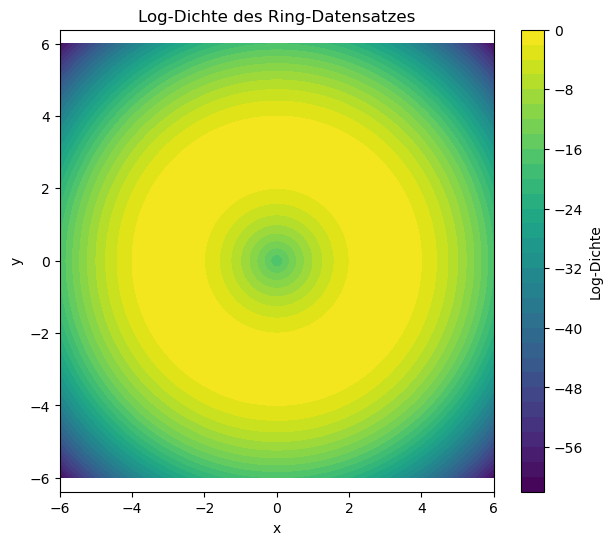

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def ring_logp_numpy(x, y):
    """
    NumPy-Version der Ring-Log-Dichte:
    x, y können auch Arrays sein.
    """
    r0 = 3.0
    sigma = 0.5
    radius = np.sqrt(x**2 + y**2)
    return -0.5 * ((radius - r0) / sigma)**2

# Gitter anlegen: z.B. von -6 bis +6 mit 200 Schritten
xs = np.linspace(-6, 6, 200)
ys = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(xs, ys)

# Logp auf dem gesamten Gitter berechnen
Z = ring_logp_numpy(X, Y)

# Konturplot
plt.figure(figsize=(7, 6))
cs = plt.contourf(X, Y, Z, levels=30, cmap="viridis")
plt.colorbar(cs, label="Log-Dichte")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.title("Log-Dichte des Ring-Datensatzes")
plt.show()


In [26]:



def validate_config(config):
    """Checks if the config correctly defines one varying attribute and all other attributes are fixed."""
    
    REQUIRED_ATTRIBUTES = {
    "config_descr",
    "posterior_type",
    "runs",
    "num_samples",
    "num_chains",
    "varying_attribute",
    "varying_values",
    }

    # Posterior-specific required attributes
    POSTERIOR_ATTRIBUTES = {
        "Cauchy": {"loc", "scale"},
        "Beta": {"a", "b"},
        "Normal": {"mu", "sigma"},
        "StudentT": {"nu", "mu", "sigma"},
        "Laplace": {"mu", "b"},
        "SkewStudentT": {"a", "b", "mu", "sigma"},
        "Mixture": {"component_types", "component_params", "weights"},
        "MvNormal": {"mu", "cov"},
        "Custom": {"logp_func"}
    }

    OPTIONAL_ATTRIBUTES = {"base_random_seed", "init_scheme", "varying_component"}

    if "config_descr" not in config:
        raise ValueError("Config is missing 'config_descr'.")
    
    config_descr = config["config_descr"]

    if "varying_attribute" not in config:
        raise ValueError(f"Config '{config_descr}' is missing 'varying_attribute'.")
    
    varying_attr = config["varying_attribute"]

    # Ensure all required attributes are present
    missing_attrs = REQUIRED_ATTRIBUTES - config.keys() - {varying_attr}

    if missing_attrs:
        raise ValueError(f"Config '{config_descr}' is missing required attributes: {missing_attrs}.")
    
    posterior_type = config["posterior_type"]

    if posterior_type not in POSTERIOR_ATTRIBUTES:
        raise ValueError(f"Config '{config_descr}' has an invalid 'posterior_type': '{posterior_type}'.")

    if posterior_type == "Mixture" and "varying_component" in config:
        varying_index = config["varying_component"]
        varying_component = config["component_types"][varying_index]
        all_valid_attributes = REQUIRED_ATTRIBUTES.union(POSTERIOR_ATTRIBUTES[posterior_type], POSTERIOR_ATTRIBUTES[varying_component], OPTIONAL_ATTRIBUTES)
        print(all_valid_attributes)

    else:
        # Ensure varying_attribute is a recognized attribute
        all_valid_attributes = REQUIRED_ATTRIBUTES.union(POSTERIOR_ATTRIBUTES[posterior_type], OPTIONAL_ATTRIBUTES)

    if varying_attr not in all_valid_attributes:
        raise ValueError(f"Config '{config_descr}' has an invalid 'varying_attribute': '{varying_attr}'.")
        
    if posterior_type == "Mixture" and varying_attr not in ("num_samples", "num_chains", "init_scheme"):
        if "varying_component" not in config:
            raise ValueError(
                f"Config '{config_descr}' must have 'varying_component' defined "
                f"when varying '{varying_attr}' for a Mixture."
            )
        
    vc = config.get("varying_component")    
    if vc is not None and not (0 <= vc < len(config["component_types"])):
        raise ValueError(
            f"Config '{config_descr}' has invalid 'varying_component' index {vc}, "
            f"but 'component_types' has length {len(config['component_types'])}."
        )
    
    VALID_INIT_SCHEMES = {"equal_per_mode", "random", "all_in_middle"} 

    if "init_scheme" in config:
        if config["init_scheme"] not in VALID_INIT_SCHEMES and not config["init_scheme"].startswith("all_near_mode_"):
            raise ValueError(
                f"Config '{config_descr}' has invalid 'init_scheme': "
                f"'{config['init_scheme']}'. Must be one of {VALID_INIT_SCHEMES} "
                "or 'all_near_mode_<int>'."
            )



# to do: if init_schme is present, check that it is a valid init scheme

# posterior_type = "Cauchy", "Beta", "Normal", "StudentT", "Laplace", "SkewstudentT"
# varying_attribute = "num_samples", "num_chains", "init_scheme" or posterior specific attribute
# bimmodal specific attributes = "mode_means", "std_of_modes", "weights"
# cauchy specific attributes = "loc", "scale"
# beta specific attributes = "a", "b"
# normal specific attributes = "mu", "sigma"
# student_t specific attributes = "nu", "mu", "sigma"
# laplace specific attributes = "mu", "b"
# skewed_student_t specific attributes = "a", "b", "mu", "sigma"
# all but the varying attribute must be fixed and present in the config

def my_custom_logp_function(x):
    w1, w2 = 0.4, 0.6
    mu1, mu2 = -2, 2
    sigma1, sigma2 = 1, 1

    log_like1 = pm.logp(pm.Normal.dist(mu=mu1, sigma=sigma1), x)
    log_like2 = pm.logp(pm.Normal.dist(mu=mu2, sigma=sigma2), x)

    return pm.math.logsumexp([np.log(w1) + log_like1, np.log(w2) + log_like2])

def ring_logp(value):
    """
    Defines the log-prob of a point in 2D:
    - value is shape (2,), where value[0] = x, value[1] = y.
    - We place mass around a circle of radius r0 with thickness sigma.
    """

    x = value[0]
    y = value[1]
    r0 = 3.0       # ring center radius
    sigma = 0.5    # ring thickness

    # radial distance from origin:
    radius = pt.sqrt(x**2 + y**2)

    # negative half-squared difference from the ring radius:
    logp_val = -0.5 * ((radius - r0) / sigma) ** 2

    # No normalizing constant needed for MCMC
    return logp_val




# default attributes
default_num_samples = 2000
default_num_chains = 4
default_base_random_seed = 42
default_runs = 3


custom_test = [

    {
            "config_descr": "Custom_mixture_normals",
            "posterior_type": "Custom",
            "runs": default_runs,
            "num_chains": default_num_chains,
            "base_random_seed": default_base_random_seed,
            "logp_func": my_custom_logp_function,
            "varying_attribute": "num_samples",
            "varying_values": [2000, 2500, 3000, 10000],
    }

]

custom_ring_test = [

    {
            "config_descr": "Custom_ring_test",
            "posterior_type": "Custom",
            "runs": default_runs,
            "num_chains": default_num_chains,
            "base_random_seed": default_base_random_seed,
            "logp_func": ring_logp,
            "varying_attribute": "num_samples",
            "varying_values": [2000, 2500, 3000, 10000],
    }

]




unimodal = [

    {
        "config_descr": "Normal",
        "posterior_type": "Normal",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [0, 2, 5, 10],
        "sigma": 1
    },

    {
        "config_descr": "Student_t",
        "posterior_type": "StudentT",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains":  default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 2, 3, 5, 30],
        "mu": 0,
        "sigma": 1,
    },

    {
        "config_descr": "Laplace_test",
        "posterior_type": "Laplace",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "b",
        "varying_values": [0.5, 1, 2, 5],
        "mu": 0,
    },
]

high_dim_and_correlated = [

        {
        "config_descr": "Mv_normal_3d_high_corr",
        "posterior_type": "MvNormal",
        "num_samples": default_num_samples,
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [
            (-5, 0, 5),
            (0, 0, 0),
            (-10, 20, -30),
            (50, -50, 100)
        ],
        "cov": [[1, 0.9, 0.85], 
              [0.9, 1, 0.88], 
              [0.85, 0.88, 1]]
    },

    {
        "config_descr": "Mv_normal_2d_low_corr",
        "posterior_type": "MvNormal",
        "num_samples": default_num_samples,
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [
            (0, 0),
            (-10, 10),
            (20, -20),
            (50, -50)
        ],
        "cov": [[1, 0.1], [0.1, 1]]
    },

    {
        "config_descr": "Mv_normal_2d_high_corr",
        "posterior_type": "MvNormal",
        "num_samples": default_num_samples,
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [
            (0, 0),
            (-10, 10),
            (20, -20),
            (50, -50)
        ],
        "cov": [[1, 0.95], [0.95, 1]] 
    },

    {
        "config_descr": "Mv_normal_3d_low_corr",
        "posterior_type": "MvNormal",
        "num_samples": default_num_samples,
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [
            (-5, 0, 5),
            (0, 0, 0),
            (-10, 20, -30),
            (50, -50, 100)
        ],
        "cov": [[1, 0.2, 0.1], 
                [0.2, 1, 0.15], 
                [0.1, 0.15, 1]]  
    }
]

multimodal = [

        {
        "config_descr": "Mv_normal_2d_mixture_3_comp",
        "posterior_type": "Mixture",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [(5, 5), (10, -10), (20, 20), (50, -50)],
        "varying_component": 1,
        "component_types": ["MvNormal", "MvNormal", "MvNormal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},  
                {"cov": [[2, 0.3], [0.3, 2]]},  
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  
        ],
        "weights": [0.3, 0.4, 0.3]
    },
    {   
        "config_descr": "Normal_and_student_t",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "StudentT"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "nu",
        "varying_values": [1, 2, 5, 10],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"nu": 3, "mu": 10, "sigma": 2}],
        "weights": [0.6, 0.4]
    }
]


difficult_geometries = [

        {
        "config_descr": "SkewStudentT",
        "posterior_type": "SkewStudentT",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "a",
        "varying_values": [1, 2, 3, 5],
        "b": 1,
        "mu": 0,
        "sigma": 1,
    },
    {
        "config_descr": "Mixture_of_SkewStudentT",
        "posterior_type": "Mixture",
        "runs": default_runs,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "num_samples": default_num_samples,
        "varying_attribute": "mu",
        "varying_values": [0, 3, 6, 10],
        "varying_component": 0,
        "component_types": ["SkewStudentT", "SkewStudentT"],
        "component_params": [
            {"a": 3, "b": 1, "sigma": 1},
            {"a": 9, "b": 3, "mu": 3, "sigma": 4}
        ],
        "weights": [0.5, 0.5]
    }
]


asymmetric_weights_mixture = [
        {
        "config_descr": "Mv_normal_2d_mixture_3_comp",
        "posterior_type": "Mixture",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [(3, 3),(5, 5), (10, 10), (20, 20), (50, 50)],
        "varying_component": 1,
        "component_types": ["MvNormal", "MvNormal", "MvNormal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},  
                {"cov": [[2, 0.3], [0.3, 2]]},  
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  
        ],
        "weights": [0.2, 0.2, 0.6]
    },

]

symmetric_weights_mixture = [
        {
        "config_descr": "Mv_normal_2d_mixture_3_comp",
        "posterior_type": "Mixture",
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [(3, 3),(5, 5), (10, 10), (20, 20), (50, 50)],
        "varying_component": 1,
        "component_types": ["MvNormal", "MvNormal", "MvNormal"],
        "component_params": [
                {"mu": [0, 0], "cov": [[1, 0.5], [0.5, 1]]},  
                {"cov": [[2, 0.3], [0.3, 2]]},  
                {"mu": [-10, -10], "cov": [[1, -0.2], [-0.2, 1]]}  
        ],
        "weights": [0.3, 0.3, 0.4]
    }
]


Mixture_test_init_scheme = [
    {   
        "config_descr": "Mixture_with_init_scheme_and_asymmetric_weights (pro DEMetro)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.1, 0.9],
        "init_scheme": "equal_per_mode"

    },

    {   
        "config_descr": "Mixture_with_asymmetric_weights (only weights)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.1, 0.9]
    },

    {   
        "config_descr": "Mixture_with_init_scheme (only init_scheme)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.5, 0.5],
        "init_scheme": "equal_per_mode"

    },
    {
        "config_descr": "Mixture_def_init_scheme_and_equal_weights (fair case)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.5, 0.5]
    },

    {   
        "config_descr": "Mixture_with_asymmetric_weights_and_random_init (only weights + random init)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.1, 0.9],
        "init_scheme": "random"
    },

    {
        "config_descr": "Mixture_random_init_scheme_and_equal_weights (random init + fair case)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.5, 0.5],
        "init_scheme": "random"
    }
]

new_mixture_test = [

    {   
        "config_descr": "Mixture_with_middle_init_scheme_and_asymmetric_weights (pro DEMetro)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.1, 0.9],
        "init_scheme": "all_in_middle"

    },     
    {   
        "config_descr": "Mixture_with_middle_init_scheme (only init_scheme)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.5, 0.5],
        "init_scheme": "all_in_middle"

    },
    {   
        "config_descr": "28_Mixture_with_init_scheme_and_less_asymmetric_weights (pro DEMetro)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.2, 0.8],
        "init_scheme": "equal_per_mode"

    },
        
    {   
        "config_descr": "37_Mixture_with_init_scheme_and_lowest_asymmetric_weights (pro DEMetro)",
        "posterior_type": "Mixture",
        "component_types": ["Normal", "Normal"],
        "runs": default_runs,
        "num_samples": default_num_samples,
        "num_chains": default_num_chains,
        "base_random_seed": default_base_random_seed,
        "varying_attribute": "mu",
        "varying_values": [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        "varying_component": 1,
        "component_params": [{"mu": 0, "sigma": 1}, {"mu": 5, "sigma": 1}],
        "weights": [0.3, 0.7],
        "init_scheme": "equal_per_mode"

    }
]




In [ ]:
def ring_logp_numpy(x, y):
    # Kopiere deine Logp-Formel, aber jetzt als NumPy-Ausdruck:
    r0 = 3.0
    sigma = 0.5
    radius = np.sqrt(x**2 + y**2)
    return -0.5 * ((radius - r0) / sigma)**2  # ohne Konstante
# 1. Erzeuge ein Gitter: z.B. von -6 bis 6 in beiden Dimensionen
xs = np.linspace(-6, 6, 200)
ys = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(xs, ys)

# 2. Berechne Logp auf dem Gitter
Z = ring_logp_numpy(X, Y)

# 3. Plot als Konturlinien oder Heatmap
plt.figure(figsize=(7,6))
# wähle z.B. contourf
levels = 30  # Anzahl der Konturlinien
cs = plt.contourf(X, Y, Z, levels=levels, cmap="viridis")
plt.colorbar(cs, label="Log-Dichte")

# 4. Achsen beschriften, Titel etc.
plt.xlabel("x")
plt.ylabel("y")
plt.title("Log-Dichte eines Ring-Distribution")
plt.axis("equal")  # gleiches Seitenverhältnis, damit Ring nicht verzerrt wird
plt.show()

In [ ]:

#experiments = [unimodal, high_dim_and_correlated, multimodal, difficult_geometries, asymmetric_weights_mixture, symmetric_weights_mixture, Mixture_test_init_scheme]
#experiments = [new_mixture_test]

experiments = [custom_test]
experiment_name = "ring_test"

# Define the root directory for all experiments
experiment_root_folder = f"exp_{experiment_name}"

# Check if the folder already exists
if os.path.exists(experiment_root_folder):
    user_input = input(
        f"Folder '{experiment_root_folder}' already exists and will be overwritten.\n"
        "Do you want to continue? (yes/no): "
    ).strip().lower()

    if user_input not in ["yes", "y"]:
        print("Operation aborted. No files were deleted.")
        sys.exit(0)

    shutil.rmtree(experiment_root_folder)

create_directories(experiment_root_folder)

# important for reduced file size (only about the individual traces, the global traces and traces per run are always saved)
experiment_settings = {
    "save_traces": False,                 # if True, save traces to NetCDF files
    "trace_plots": "first_run_only",                # "none", "first_run_only", "all" 
    "plot_traces_in_notebook": False       # if True, plot traces in the notebook
}

failed_configs = []
start_time = time.time()
start_dt = datetime.now()

# Validate all configurations before running the experiments
for exp in experiments:
    for config in exp:
        validate_config(config)


total_runs = sum(config["runs"] for exp in experiments for config in exp)
print(f"Total number of runs: {total_runs}")

print("All configurations are valid. Starting experiments...")
with tqdm(total=total_runs, desc="Total experiment progress") as pbar:
    for exp in experiments:
        for config in exp:
            try:
                run_experiment(
                    experiment_settings,
                    posterior_type=config["posterior_type"],
                    config_descr=config["config_descr"],
                    runs=config["runs"],
                    varying_attribute=config["varying_attribute"],
                    varying_values=config["varying_values"],
                    init_scheme="varies" if config["varying_attribute"] == "init_scheme" else config.get("init_scheme", None),
                    num_samples="varies" if config["varying_attribute"] == "num_samples" else config["num_samples"],
                    num_chains="varies" if config["varying_attribute"] == "num_chains" else config["num_chains"],
                    base_random_seed=config.get("base_random_seed", None),
                    progress_bar=pbar, 
                    **{k: v for k, v in config.items() if k not in [
                        "config_descr", "runs", "varying_attribute", "varying_values", 
                        "num_samples", "num_chains", "init_scheme", 
                        "base_random_seed", "posterior_type"
                    ]}  # Pass remaining keys as posterior_kwargs
                )
            except Exception as e:
                print(f"Error in config '{config['config_descr']}': {e}")
                failed_configs.append((config['config_descr'], str(e)))

end_time = time.time()
end_dt = datetime.now()
duration = end_time - start_time
hours = int(duration // 3600)
minutes = int((duration % 3600) // 60)
seconds = round(duration % 60, 1)

def get_folder_size(path='.'):
    """Compute total size of all files in directory."""
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total += os.path.getsize(fp)
    return total

# Prepare the summary text
size_bytes = get_folder_size(experiment_root_folder)
total_configs = sum(len(exp) for exp in experiments)

summary_lines = [
    "\n============================",
    "Experiment Summary",
    "============================",
    f"Started at:               {start_dt.strftime('%Y-%m-%d %H:%M:%S')}",
    f"Finished at:              {end_dt.strftime('%Y-%m-%d %H:%M:%S')}",
    f"Total duration:           {hours}h {minutes}m {seconds}s",
    f"Output folder:            {experiment_root_folder}",
    f"Output folder size:       {humanize.naturalsize(size_bytes)}",
    f"Total configurations:     {total_configs}",
    f"Successful runs:          {total_configs - len(failed_configs)}",
    f"Failed configurations:    {len(failed_configs)}"
]

if failed_configs:
    summary_lines.append("\n Failed Configurations:")
    for cfg, msg in failed_configs:
        summary_lines.append(f" - {cfg}: {msg}")

# Print to console
print("\n".join(summary_lines))

# Also save to summary.txt
summary_path = os.path.join(experiment_root_folder, "summary.txt")
with open(summary_path, "w") as f:
    f.write("\n".join(summary_lines))

print(f"Summary saved to: {summary_path}")


Total number of runs: 3
All configurations are valid. Starting experiments...


Total experiment progress:   0%|          | 0/3 [00:00<?, ?it/s]


===== Config Custom_mixture_normals started! =====

Using IID sample settings: {}

===== Running Custom_mixture_normals - Run 1 =====

Running Metro with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running Metro with num_samples = 2500


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 2500


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 2500


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running Metro with num_samples = 3000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 3000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 3000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running Metro with num_samples = 10000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 10000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 10000


Total experiment progress:  33%|███▎      | 1/3 [09:09<18:19, 549.76s/it]


===== Running Custom_mixture_normals - Run 2 =====

Running Metro with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running Metro with num_samples = 2500


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 2500


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 2500


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running Metro with num_samples = 3000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 3000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 3000
Running Metro with num_samples = 10000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 10000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running DEMetro with num_samples = 10000


Total experiment progress:  67%|██████▋   | 2/3 [17:40<08:46, 526.99s/it]


===== Running Custom_mixture_normals - Run 3 =====

Running Metro with num_samples = 2000


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running HMC with num_samples = 2000
